# LOAD LIB

In [32]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import numpy as np
from collections import Counter
from collections import defaultdict
from scipy.signal import stft
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report

# Load data

In [33]:
# Load file from folder
def load_files_with_labels(folders):
    data = []
    labels = []
    for label, src_folder in folders.items():
        for root, _, files in os.walk(src_folder):
            for file in files:
                file_path = os.path.join(root, file)
                data.append(file_path)
                labels.append(label)
    return data, labels

# Display image of cake
def display_image(data, labels, index):
    img_path = data[index]
    img = cv2.imread(img_path)
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width = img.shape[:2]
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.title(f"{labels[index]} ({width}x{height})")
        plt.axis('off')
    else:
        plt.figure(figsize=(10, 10))
        plt.title(f"Error loading {data[index]}")
        plt.axis('off')
    plt.show()

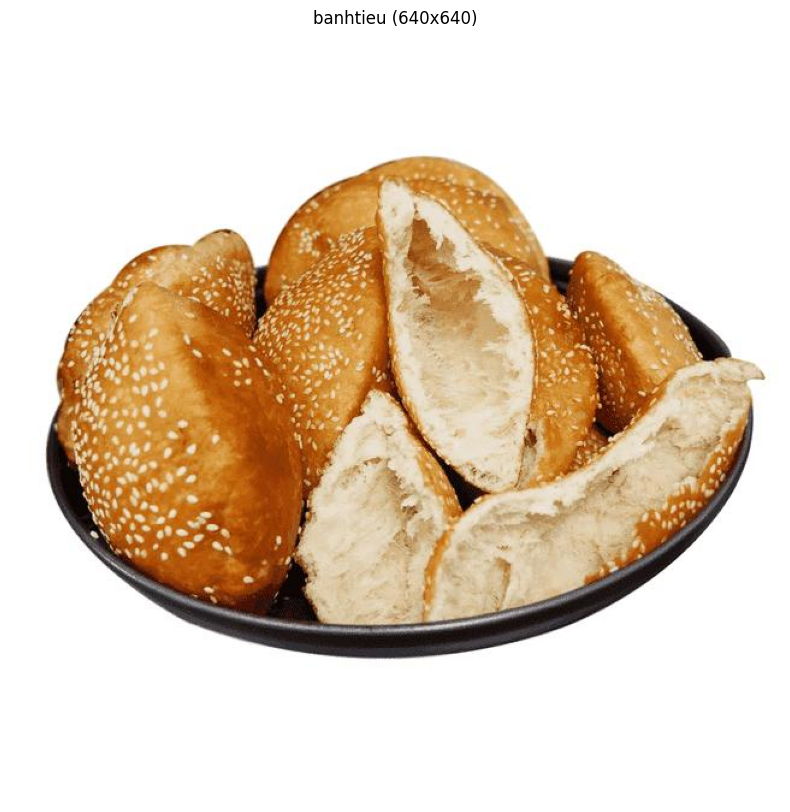

In [34]:
folders = {
    'banhcay': '/kaggle/input/banhvn/BanhVN/BanhCay',
    'banhcay_bosung': '/kaggle/input/banhvn/BanhVN/data_agumentation/BanhCay',
    'banhchung': '/kaggle/input/banhvn/BanhVN/BanhChung',
    'banhchung_bosung': '/kaggle/input/banhvn/BanhVN/data_agumentation/BanhChung',
    'banhgio': '/kaggle/input/banhvn/BanhVN/BanhGiayGio',
    'banhgio_bosung': '/kaggle/input/banhvn/BanhVN/data_agumentation/BanhGiayGio',
    'banhpia': '/kaggle/input/banhvn/BanhVN/BanhPia',
    'banhpia_bosung': '/kaggle/input/banhvn/BanhVN/data_agumentation/BanhPia',
    'banhtai': '/kaggle/input/banhvn/BanhVN/BanhTaiHeo',
    'banhtai_bosung': '/kaggle/input/banhvn/BanhVN/data_agumentation/BanhTaiHeo',
    'banhtieu': '/kaggle/input/banhvn/BanhVN/BanhTieu',
    'banhtieu_bosung': '/kaggle/input/banhvn/BanhVN/data_agumentation/BanhTieu'
}

data, labels = load_files_with_labels(folders)
display_image(data, labels, index=1000)

# Preprocessing

In [35]:
# Edit labels
def update_labels_and_data(labels, data):
    mapping = {f"{key}_bosung": key for key in set(label.replace('_bosung', '') for label in labels)}
    updated_labels = [mapping.get(label, label) for label in labels]
    label_to_indices = defaultdict(list)
    
    for index, label in enumerate(updated_labels):
        label_to_indices[label].append(index)
    updated_data = [''] * len(data)
    
    for label, indices in label_to_indices.items():
        for index in indices:
            updated_data[index] = data[index]
    
    return updated_data, updated_labels


def preprocessing(img_path, target_size=(256, 256)):
    images = {
        'original': None,
        'resized': None,
        'hsv': None,
        'denoised': None,
        'equalized': None
    }
    
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Unable to load image {img_path}")
        return None, None
        
    images['original'] = img
        
    # Resize to the same size 
    img_resized = cv2.resize(img, target_size)
    images['resized'] = img_resized
        
    # Convert to color space
    img_hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    images['hsv'] = img_hsv
        
    # Denoise = GaussianBlur
    img_denoised = cv2.GaussianBlur(img_hsv, (3, 3), 0)
    images['denoised'] = img_denoised
        
    # Light balance
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    img_clahe = img_denoised.copy()
    img_clahe[:, :, 2] = clahe.apply(img_denoised[:, :, 2])
    images['equalized'] = img_clahe
    
    # Convert from HSV to BGR
    img_result = cv2.cvtColor(img_clahe, cv2.COLOR_HSV2BGR)
    
    # Using for training
    img_array = np.array(img_result) / 255.0
    img_array = np.transpose(img_array, (2, 0, 1))
    
    return images, img_array

# Display image for preprocessing
def display_images_step_by_step(images):
    steps = ['original', 'resized', 'hsv', 'denoised', 'equalized']
    for step in steps:
        img = images[step]
        if img is None:
            continue
        if step == 'hsv' or step in ['denoised', 'equalized']:
            img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(step)
        plt.axis('off')
        plt.show()

Label and image: 


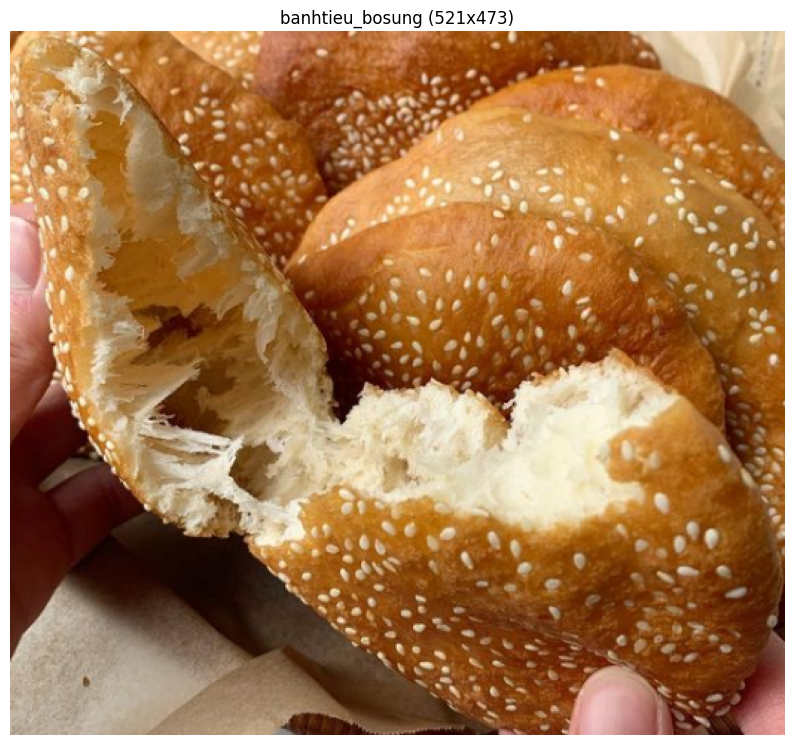

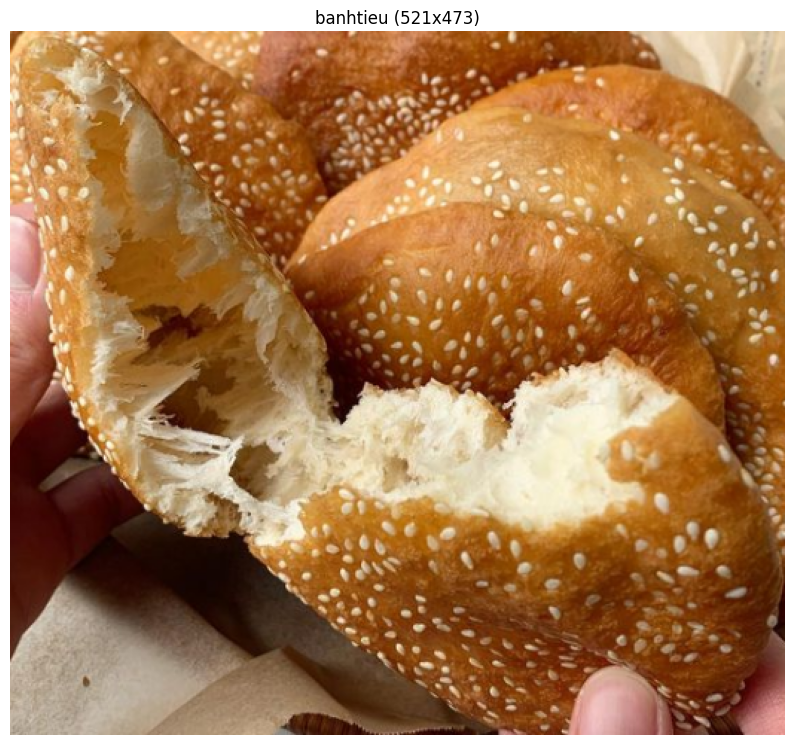

In [36]:
# Edit labels
updated_data, updated_labels = update_labels_and_data(labels, data)
print("Label and image: ")

display_image(data, labels, index=1077)
display_image(updated_data, updated_labels, index=1077)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


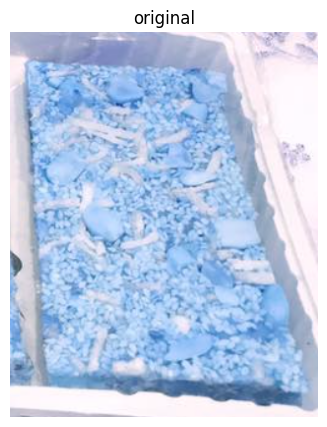

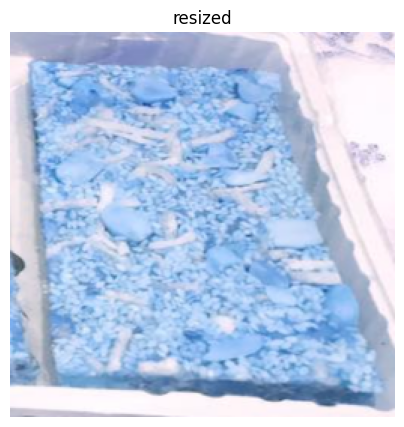

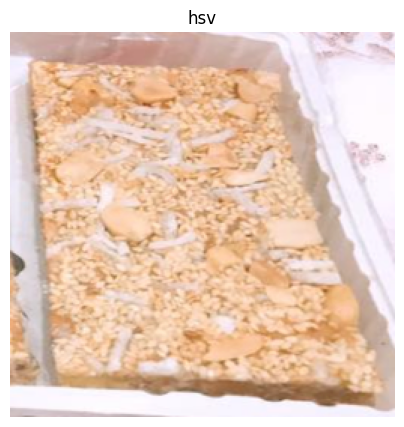

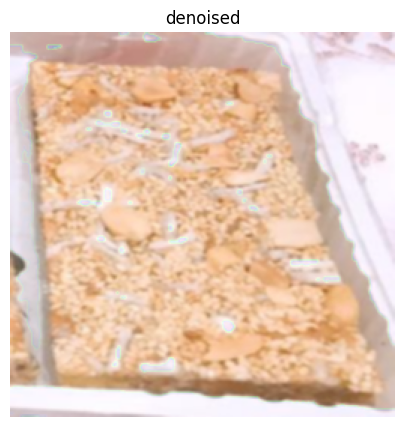

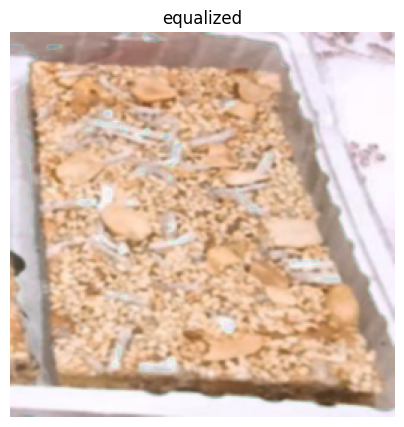

In [37]:
processed_images, img_arrays = zip(*[preprocessing(img_path) for img_path in updated_data if preprocessing(img_path)[0] is not None])
img_array = np.array(img_arrays)
display_images_step_by_step(processed_images[0])

In [38]:
print("Shape of image data: ", img_array.shape) # (N, C, H, W) = (samples, channels, height, weight)

Shape of image data:  (1080, 3, 256, 256)


# Training

In [39]:
def training(trainloader, valloader, model, optimizer, criterion, device, epochs, H):
    print("Start Training...\n")
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total_train = 0
        train_correct = 0
        start_time = time.time()
        
        for x_train, y_train in trainloader:
            x_train, y_train = x_train.to(device), y_train.to(device)
            x_train = x_train.float()
            
            optimizer.zero_grad()
            pred_train = model(x_train)
            
            # Tính toán mất mát cho phân loại đa lớp
            loss_train = criterion(pred_train, y_train)
            
            loss_train.backward()
            optimizer.step()
            
            train_loss += loss_train.item()
            total_train += y_train.size(0)
            
            # Phân loại đa lớp
            _, pred_class = torch.max(pred_train, 1)
            train_correct += (pred_class == y_train).sum().item()
        
        avg_train_loss = train_loss / len(trainloader)
        train_accuracy = 100 * train_correct / total_train
        
        # Cập nhật lịch sử huấn luyện
        H["train_loss"].append(avg_train_loss)
        H["train_acc"].append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss = 0
        total_val = 0
        val_correct = 0
        
        with torch.no_grad():
            for x_val, y_val in valloader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                x_val = x_val.float()
                
                pred_val = model(x_val)
                loss_val = criterion(pred_val, y_val)
                
                val_loss += loss_val.item()
                total_val += y_val.size(0)
                
                _, pred_class = torch.max(pred_val, 1)
                val_correct += (pred_class == y_val).sum().item()
        
        avg_val_loss = val_loss / len(valloader)
        val_accuracy = 100 * val_correct / total_val
        
        H["val_loss"].append(avg_val_loss)
        H["val_acc"].append(val_accuracy)
        
        end_time = time.time()
        epoch_time = end_time - start_time

        print("[INFO] EPOCH: {}/{}".format(epoch + 1, epochs), end=" ")
        print("Train loss: {:.6f}, Train accuracy: {:.4f}, Validation loss: {:.6f}, Validation accuracy: {:.4f}".format(avg_train_loss, train_accuracy, avg_val_loss, val_accuracy))
        print("Time taken for epoch: {:.2f} seconds".format(epoch_time), "\n")

def plotloss(H):
    plt.figure(figsize=(16, 8))
    plt.plot(H["train_loss"], label='Train', marker='o')
    plt.plot(H["val_loss"], label='Val', marker='x')
    plt.title("Loss between TRAIN and VAL")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

## Baseline model

In [40]:
class CNN(nn.Module):
    def __init__(self, input_feature, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_feature, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 32 * 32, 64)
        self.bn4 = nn.BatchNorm1d(64)
        
        self.fc2 = nn.Linear(64, num_classes)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = self.drop(x)
        
        x = x.view(-1, 64 * 32 * 32) 

        x = F.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)
        x = self.drop(x)
        return x


# Evaluation

In [41]:
def testing(model, val_loader, criterion, device):
    print("Start Testing........\n")

    all_true_labels = []
    all_predicted_labels = []

    for (x_test, y_test) in val_loader:
        model.eval()  # Set the model to evaluation mode
        x_test, y_test = x_test.to(device), y_test.to(device)
        x_test = x_test.float()

        # Forward pass
        with torch.no_grad():
            pred_test = model(x_test)
        # Calculate test loss
        loss_test = criterion(pred_test, y_test)
        # Calculate test accuracy
        testCorrect = (pred_test.argmax(1) == y_test).sum().item()
        total_test = y_test.size(0)
        testAccuracy = 100 * testCorrect / total_test
        
        all_true_labels.extend(y_test.cpu().numpy())
        all_predicted_labels.extend(pred_test.argmax(1).cpu().numpy())

    print("[======================================================================] \n\nStop Testing........\n")
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)

    print("\nClassification Report on Each Class Across All Batches:\n", classification_report(all_true_labels, all_predicted_labels))
    
def predict_image(image_path, model):
    # Tiền xử lý ảnh
    processed_images, img_array = preprocessing(image_path)
    display_images_step_by_step(processed_images)
    
    # Chuyển ảnh và mô hình sang thiết bị
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    img_tensor = torch.tensor(img_array).to(device).float().unsqueeze(0)
    model.to(device)

    # Đánh giá mô hình
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
    
    return predicted.item()

# Main

In [42]:
# Encode nhãn chuỗi thành số
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(updated_labels)

# Chuyển đổi dữ liệu thành tensor
X_tensor = torch.tensor(img_array, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)  # Sử dụng torch.long cho các lớp phân loại

# Chia dữ liệu
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Tạo Dataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

In [43]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN(3, 6)
model.to(device)

# Sử dụng weight decay (L2 regularization)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()
H = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

Start Training...

[INFO] EPOCH: 1/50 Train loss: 1.280993, Train accuracy: 51.5046, Validation loss: 1.612355, Validation accuracy: 37.5000
Time taken for epoch: 1.23 seconds 

[INFO] EPOCH: 2/50 Train loss: 0.950171, Train accuracy: 67.1296, Validation loss: 0.946970, Validation accuracy: 81.0185
Time taken for epoch: 1.22 seconds 

[INFO] EPOCH: 3/50 Train loss: 0.754651, Train accuracy: 76.5046, Validation loss: 0.788269, Validation accuracy: 85.6481
Time taken for epoch: 1.22 seconds 

[INFO] EPOCH: 4/50 Train loss: 0.718742, Train accuracy: 76.9676, Validation loss: 0.734534, Validation accuracy: 88.4259
Time taken for epoch: 1.24 seconds 

[INFO] EPOCH: 5/50 Train loss: 0.641325, Train accuracy: 79.2824, Validation loss: 0.720551, Validation accuracy: 89.8148
Time taken for epoch: 1.22 seconds 

[INFO] EPOCH: 6/50 Train loss: 0.606156, Train accuracy: 80.6713, Validation loss: 0.663114, Validation accuracy: 89.8148
Time taken for epoch: 1.22 seconds 

[INFO] EPOCH: 7/50 Train lo

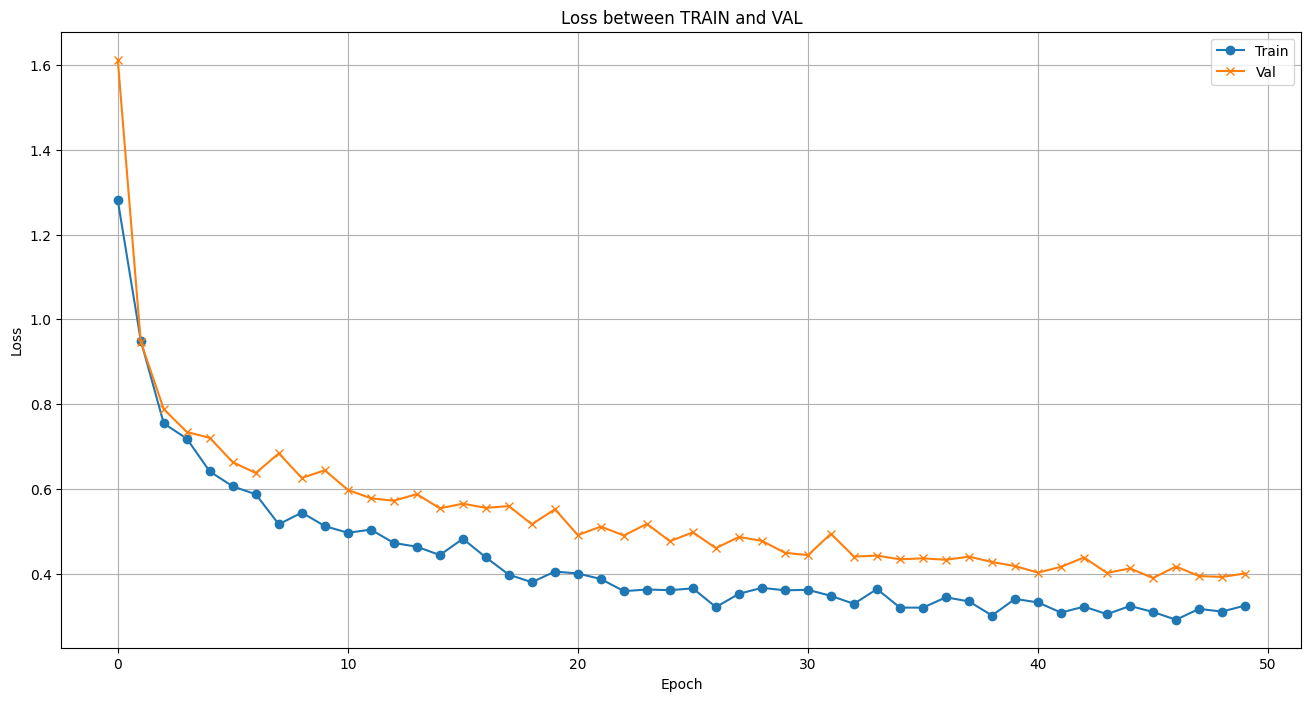

In [44]:
import time
training(train_loader, val_loader, model, optimizer, criterion, device, 50, H)
plotloss(H)

In [45]:
testing(model, val_loader, criterion, device)

Start Testing........

[======================================================================] 

Stop Testing........


Classification Report on Each Class Across All Batches:
               precision    recall  f1-score   support

           0       0.76      0.97      0.85        36
           1       0.86      0.89      0.88        36
           2       0.95      0.95      0.95        40
           3       0.91      0.94      0.92        31
           4       0.96      0.79      0.87        33
           5       0.97      0.82      0.89        40

    accuracy                           0.89       216
   macro avg       0.90      0.89      0.89       216
weighted avg       0.90      0.89      0.89       216



In [46]:
torch.save(model.state_dict(), '/kaggle/working/cnnbanhvn.pth')

# # Tải trọng số vào mô hình
# model = CNN(3, 6)
# model.load_state_dict(torch.load('/kaggle/working/cnnbanhvn.pth'))

# # Chuyển mô hình sang chế độ đánh giá
# model.eval()